## daily data updates for the helioforecast.space website 

NOAA L1 and STEREO-A

Main author: C. Möstl, Austrian Space Weather Office, GeoSphere Austria

https://github.com/cmoestl/heliocats

data_update_web.py

uses environment 'envs/env_helio4.yml'

for updating data every day on the servers

Issues:

- change to last 400 days



In [1]:
#switches
debug_mode=0

#switches
get_noaa=1
get_stereoa=1


import pickle
import importlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import sys
import numpy as np
import datetime
import scipy.signal
import urllib
import json
import os   
import time
import h5py
import pytz
import copy
import cdflib

from heliocats import data as hd
from heliocats import plot as hp


##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    matplotlib.use('Agg') 
#mac
if sys.platform =='darwin':  
    print('system is mac')
    %matplotlib inline     



################################################ CHECK  ##############################################
os.system('jupyter nbconvert --to script data_update_web.ipynb')   


####################################################################################################################


#test execution times
t0all = time.time()


/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


system is mac


[NbConvertApp] Converting notebook data_update_web.ipynb to script
[NbConvertApp] Writing 8692 bytes to data_update_web.py


### Configure paths depending on server or local machine


In [2]:
if sys.platform == 'linux': 
    
    from config_server import data_path
    from config_server import noaa_path
    from config_server import wind_path
    from config_server import stereoa_path
    from config_server import data_path_ml
    
if sys.platform =='darwin':  

    from config_local import data_path
    from config_local import noaa_path
    from config_local import wind_path
    from config_local import stereoa_path
    from config_local import data_path_ml

print(' ')
print('------ PATHS ')

print(data_path)
print(noaa_path)
print(wind_path)
print(stereoa_path)
print(data_path_ml)


plot_path=data_path+'plots/'
position_path=data_path+'plots_positions/'
sun_path=data_path+'plots_sun/'

print(plot_path)
print(position_path)



########### make directories first time
if os.path.isdir(plot_path) == False: os.mkdir(plot_path)
if os.path.isdir(plot_path+'omni2') == False: os.mkdir(plot_path+'omni2')
if os.path.isdir(plot_path+'wind') == False: os.mkdir(plot_path+'wind')
if os.path.isdir(plot_path+'stereoa') == False: os.mkdir(plot_path+'stereoa')
if os.path.isdir(plot_path+'combined') == False: os.mkdir(plot_path+'combined')


if os.path.isdir(position_path) == False: os.mkdir(position_path)
if os.path.isdir(sun_path) == False: os.mkdir(sun_path)
if os.path.isdir(noaa_path) == False: os.mkdir(noaa_path)
if os.path.isdir(data_path_ml) == False: os.mkdir(data_path_ml)

 
------ PATHS 
/Users/chris/python/data/insitu_python/
/Users/chris/python/ops/data/noaa/
/Users/chris/python/data/wind/
/Users/chris/python/data/stereoa/
/Users/chris/python/data/insitu_python/ML_struct_arrays/
/Users/chris/python/data/insitu_python/plots/
/Users/chris/python/data/insitu_python/plots_positions/


### positions and SDO plot

 
------ POSITIONS 
saved as  /Users/chris/python/data/insitu_python/plots_positions/positions_2023_Sep_24.png
saved as  /Users/chris/python/data/insitu_python/plots_positions/positions_now.p
saved as  /Users/chris/python/data/insitu_python/plots_positions/positions_now.txt
saved as  /Users/chris/python/data/insitu_python/plots_positions/positions_now.png


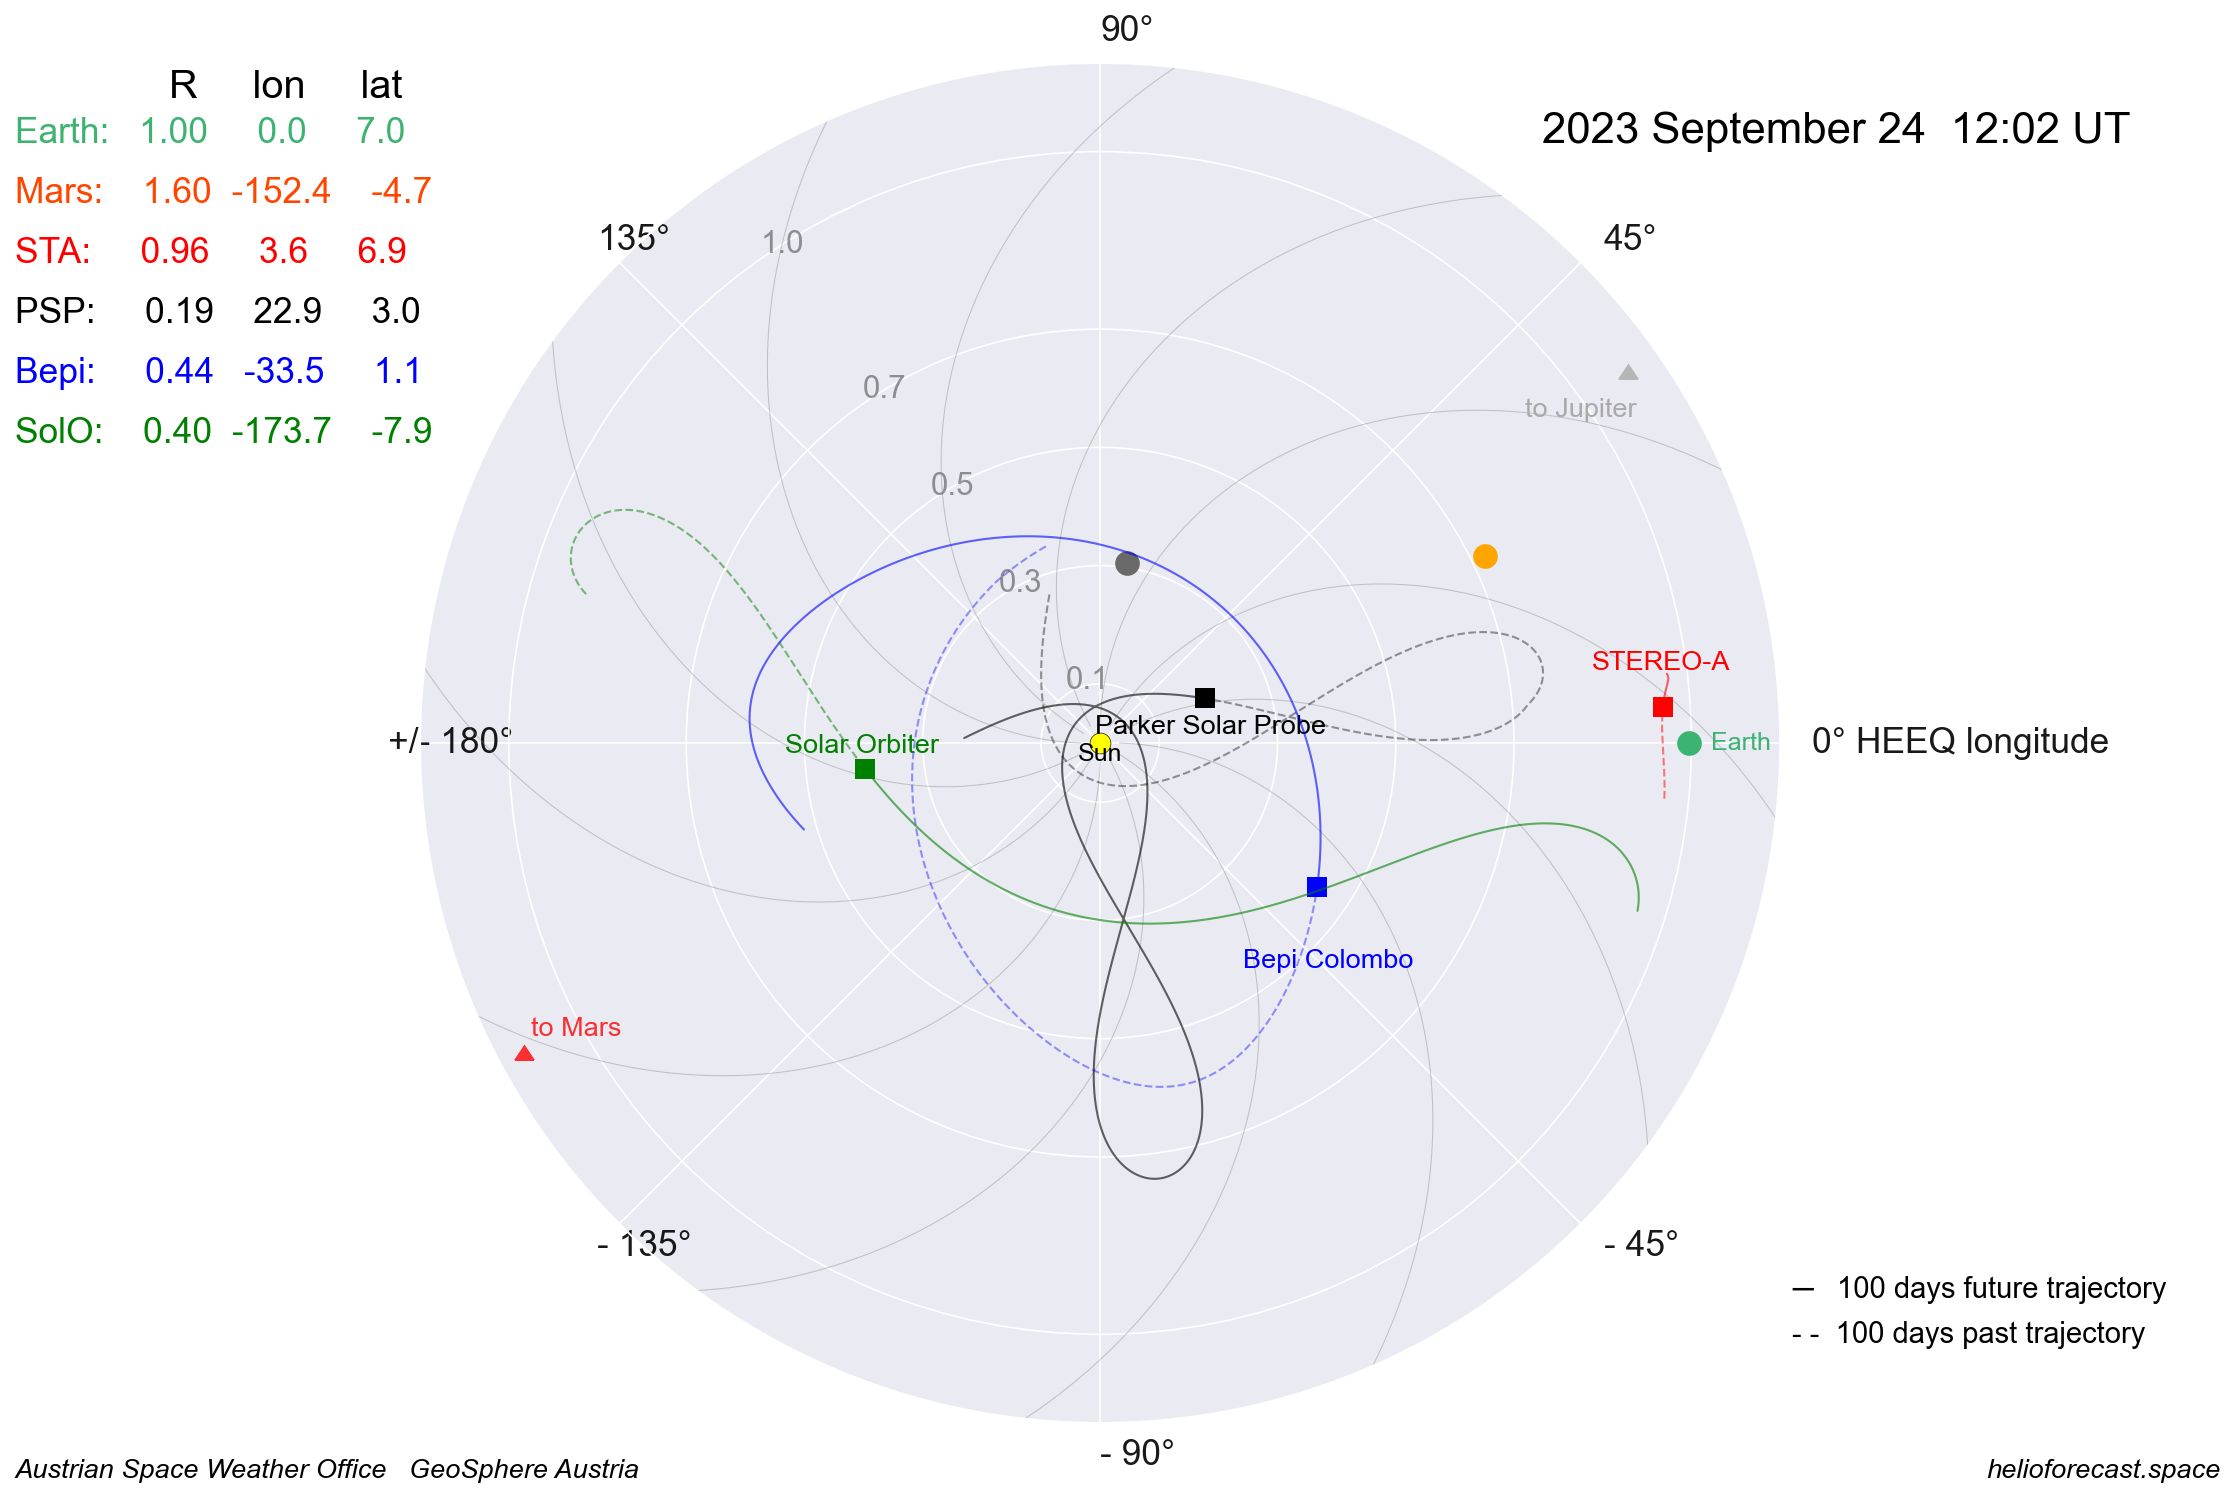

/Users/chris/python/ops/data/noaa/xray/xray-7-day_2023-09-24.json
 
------ SDO realtime images 
saved  /Users/chris/python/data/insitu_python/plots_sun/latest_1024_0193.jpg
2023-09-24 11:48 UT


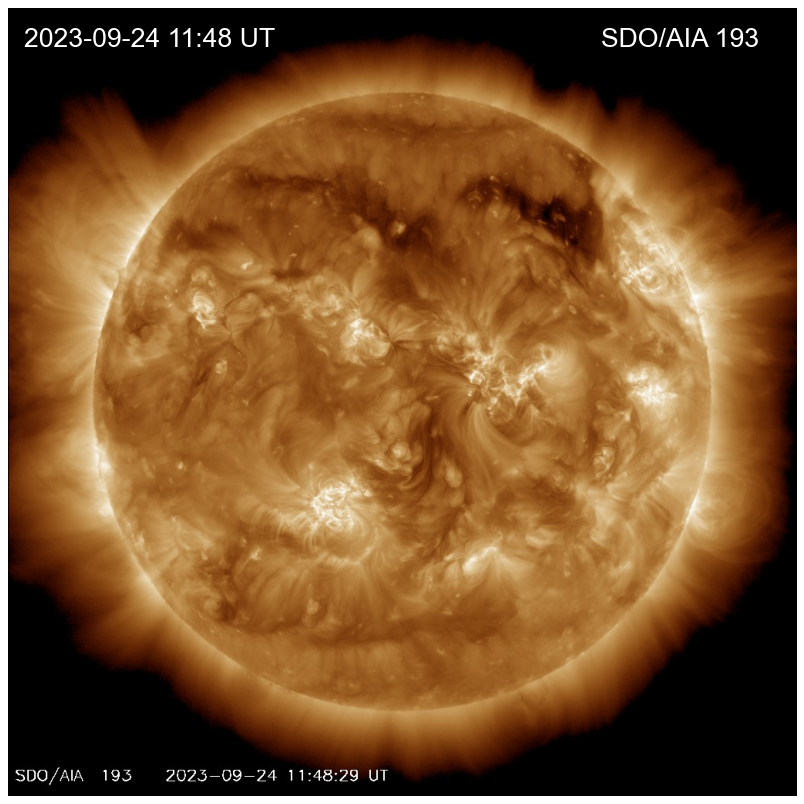

saved  /Users/chris/python/data/insitu_python/plots_sun/latest_1024_HMIB.jpg
2023-09-24 11:15 UT


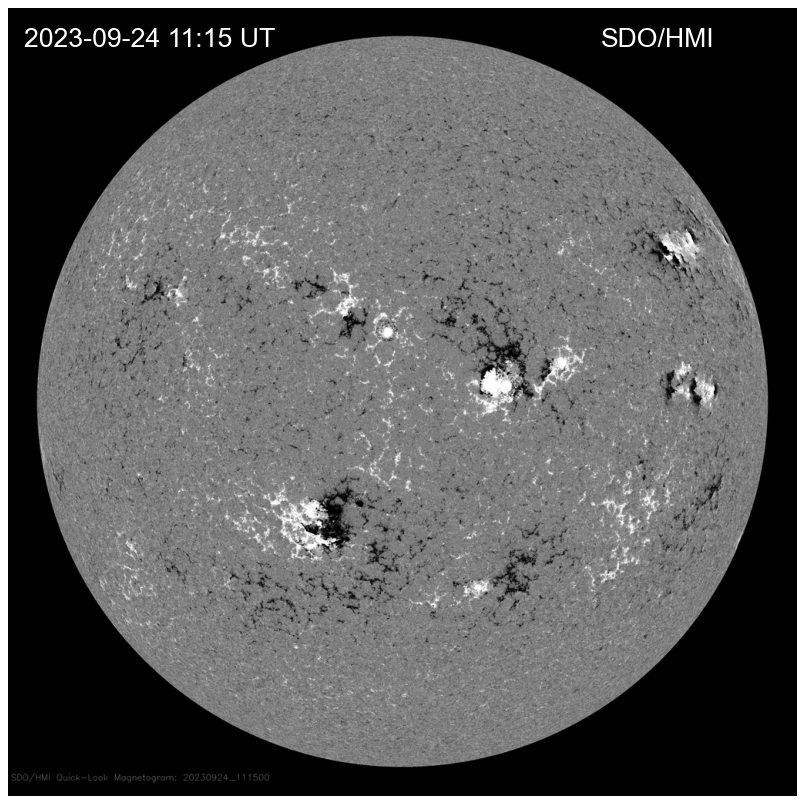


Positions and SDO images takes 20.74 seconds


In [3]:
#if debug_mode > 0: 
importlib.reload(hd) 
importlib.reload(hp) 


t0 = time.time()
print(' ')
print('------ POSITIONS ')

# spacecraft positions image
hp.plot_positions(datetime.datetime.utcnow(),position_path, 'HEEQ',now=True)


#get NOAA xray file and plot on SDO map
xray='https://services.swpc.noaa.gov/json/goes/primary/xrays-7-day.json'

datestr=str(datetime.datetime.utcnow().strftime("%Y-%m-%d"))
try: 
    urllib.request.urlretrieve(xray, noaa_path+'xray/xrays-7-day_'+datestr+'.json')
    print(noaa_path+'xray/xray-7-day_'+datestr+'.json')
except urllib.error.URLError as e:
    print(' ', xray,' ',e.reason)



print(' ')
print('------ SDO realtime images ')
# get current SDO images 
hd.get_sdo_realtime_image(sun_path)

t1 = time.time()
print()
print('Positions and SDO images takes', np.round(t1-t0,2), 'seconds')

### NOAA real time solar wind and Dst

 
------ NOAA real time solar wind data 
download NOAA real time solar wind plasma and mag and dst
2023-09-24 UTC
/Users/chris/python/ops/data/noaa/ephem/ephemerides_2023-09-24.json
/Users/chris/python/ops/data/noaa/plasma/plasma-7-day_2023-09-24.json
/Users/chris/python/ops/data/noaa/mag/mag-7-day_2023-09-24.json
/Users/chris/python/ops/data/noaa/dst/dst-7-day_2023-09-24.json
NOAA RTSW download complete
 
convert NOAA real time solar wind archive to pickle file
directories for the json data
/Users/chris/python/ops/data/noaa/mag/
Sorted file list to be read with cutoff  300  files. 
['mag-7-day_2023-06-06T23h.json' 'mag-7-day_2023-06-07T05h.json'
 'mag-7-day_2023-06-07T11h.json' 'mag-7-day_2023-06-07T17h.json'
 'mag-7-day_2023-06-07T23h.json' 'mag-7-day_2023-06-08T05h.json'
 'mag-7-day_2023-06-08T11h.json' 'mag-7-day_2023-06-08T17h.json'
 'mag-7-day_2023-06-08T23h.json' 'mag-7-day_2023-06-09T05h.json'
 'mag-7-day_2023-06-09T11h.json' 'mag-7-day_2023-06-09T17h.json'
 'mag-7-day_2023-06-

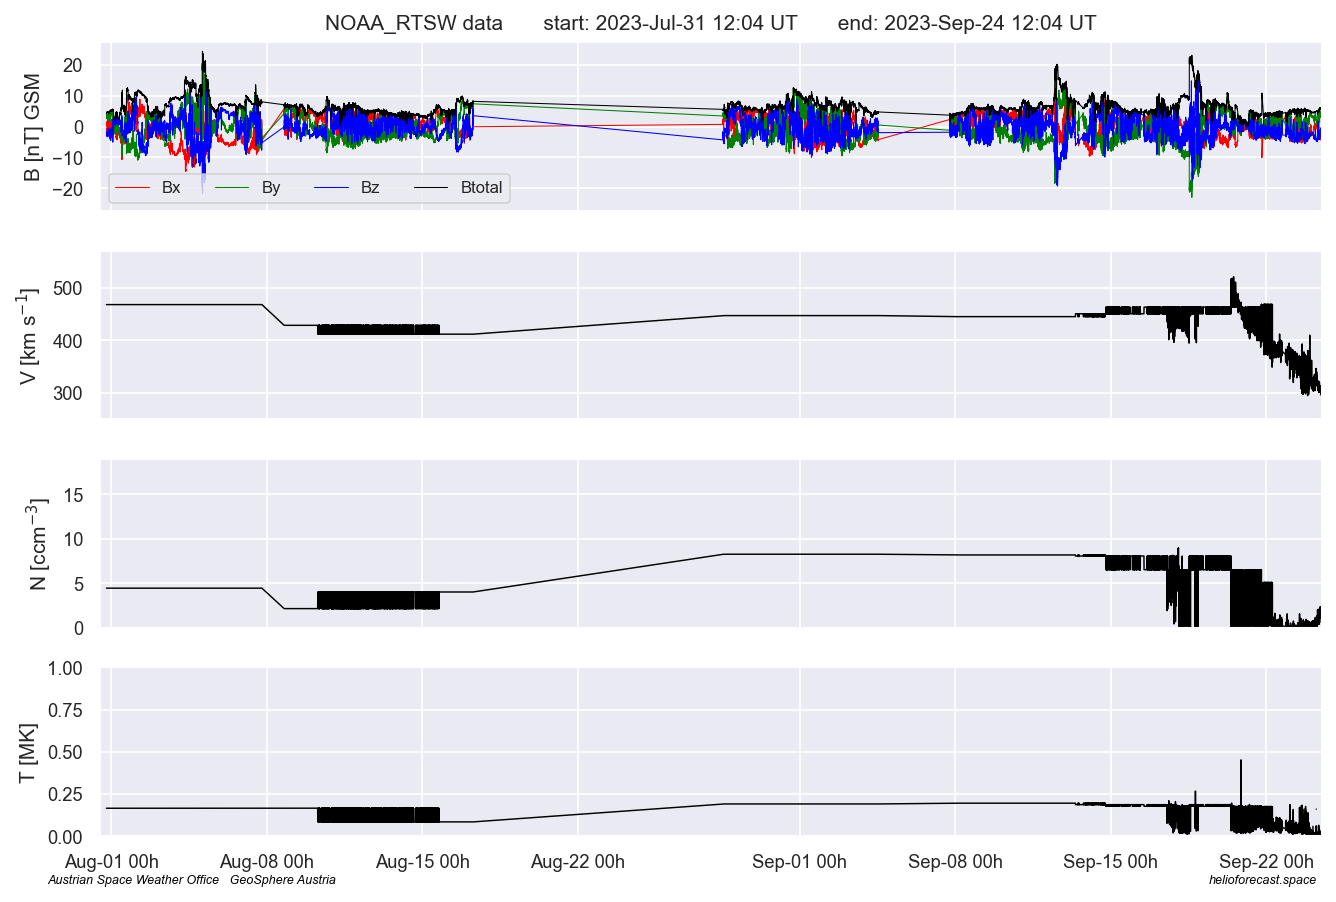

In [4]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

print(' ')
print('------ NOAA real time solar wind data ')

#test execution times
t0 = time.time()

filenoaa='noaa_rtsw_last_300files_now.p'
filedst='noaa_dst_last_300files_now.p'


if get_noaa > 0:
    print('download NOAA real time solar wind plasma and mag and dst')
    datestr=str(datetime.datetime.utcnow().strftime("%Y-%m-%d"))
    print(datestr+' UTC')

    
    #solar wind
    ephem='http://services.swpc.noaa.gov/products/solar-wind/ephemerides.json' 
    plasma='http://services.swpc.noaa.gov/products/solar-wind/plasma-7-day.json'
    mag='http://services.swpc.noaa.gov/products/solar-wind/mag-7-day.json'
    
    dst='https://services.swpc.noaa.gov/products/kyoto-dst.json'
    
    
    try: 
        urllib.request.urlretrieve(ephem, noaa_path+'ephem/ephemerides_'+datestr+'.json')
        print(noaa_path+'ephem/ephemerides_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', ephem,' ',e.reason)


    try: 
        urllib.request.urlretrieve(plasma, noaa_path+'plasma/plasma-7-day_'+datestr+'.json')
        print(noaa_path+'plasma/plasma-7-day_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', plasma,' ',e.reason)

    try: 
        urllib.request.urlretrieve(mag, noaa_path+'mag/mag-7-day_'+datestr+'.json')
        print(noaa_path+'mag/mag-7-day_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', mag,' ',e.reason)
        

    try: 
        urllib.request.urlretrieve(dst, noaa_path+'dst/dst-7-day_'+datestr+'.json')
        print(noaa_path+'dst/dst-7-day_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', mag,' ',e.reason)
 
    print('NOAA RTSW download complete')
    
    
           
    ## SAVE NOAA DATA AS PICKLE, dst as extra file
    # last parameter gives a cutoff, so only the latest N files are taken for the NOAA data pickle file
    
    #make the last 300 files
    hd.save_noaa_rtsw_data(data_path,noaa_path,filenoaa,filedst,300)
    
    
    print('NOAA RTSW saved as pickle file complete')


else:
    print('NOAA data NOT downloaded and saved as pickle, turn on switch')  
 
    
[noaa,hnoaa]=pickle.load(open(data_path+filenoaa, "rb" ) ) 

#load dst file
#dst=pickle.load(open(data_path+filedst, "rb" ) ) 

 

#plot
start=datetime.datetime.utcnow() - datetime.timedelta(days=55)
end=datetime.datetime.utcnow() 
hp.plot_insitu_update_noaa_rtsw(noaa, start, end,'NOAA_RTSW',plot_path+'noaa/',now2=True)


t1 = time.time()

print()
print('NOAA download latest file, save as pickle last 300 files and plotting takes', np.round(t1-t0,2), 'seconds')

    

### STEREO-A beacon data

 
------ STEREO-A beacon data 
 
--- download STEREO-A beacon data last 30 days 
download STEREO-A beacon data to  /Users/chris/python/data/stereoa/
STA_LB_IMPACT_20230718_V02.cdf
STA_LB_PLASTIC_20230718_V14.cdf
STA_LB_IMPACT_20230719_V02.cdf
STA_LB_PLASTIC_20230719_V14.cdf
STA_LB_IMPACT_20230720_V02.cdf
STA_LB_PLASTIC_20230720_V14.cdf
STA_LB_IMPACT_20230721_V02.cdf
STA_LB_PLASTIC_20230721_V14.cdf
STA_LB_IMPACT_20230722_V02.cdf
STA_LB_PLASTIC_20230722_V14.cdf
STA_LB_IMPACT_20230723_V02.cdf
STA_LB_PLASTIC_20230723_V14.cdf
STA_LB_IMPACT_20230724_V02.cdf
STA_LB_PLASTIC_20230724_V14.cdf
STA_LB_IMPACT_20230725_V02.cdf
STA_LB_PLASTIC_20230725_V14.cdf
STA_LB_IMPACT_20230726_V02.cdf
STA_LB_PLASTIC_20230726_V14.cdf
STA_LB_IMPACT_20230727_V02.cdf
STA_LB_PLASTIC_20230727_V14.cdf
STA_LB_IMPACT_20230728_V02.cdf
STA_LB_PLASTIC_20230728_V14.cdf
STA_LB_IMPACT_20230729_V02.cdf
STA_LB_PLASTIC_20230729_V14.cdf
STA_LB_IMPACT_20230730_V02.cdf
STA_LB_PLASTIC_20230730_V14.cdf
STA_LB_IMPACT_20230731_V02.cdf
S

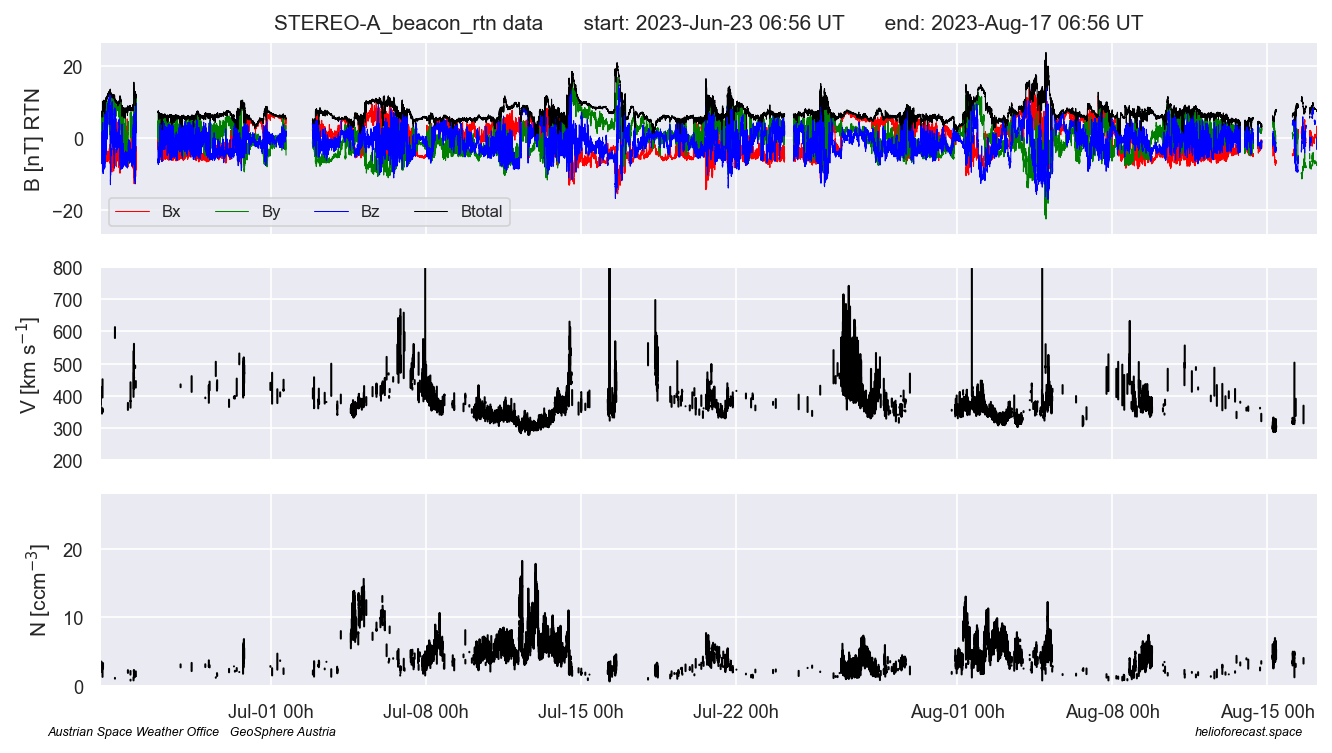

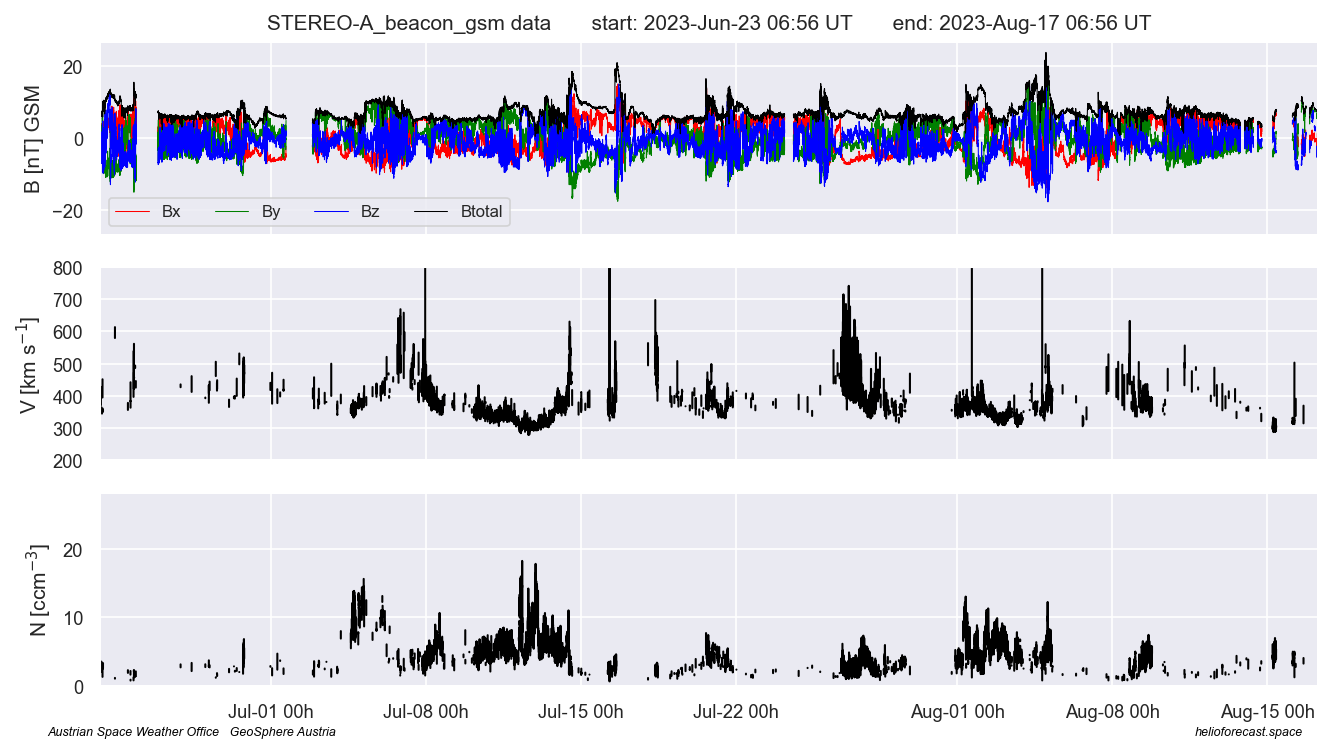

In [5]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

#test execution times
t0 = time.time()


print(' ')
print('------ STEREO-A beacon data ')

#define filename
file_sta_beacon_rtn='stereoa_beacon_rtn_last_300days_now.p'   
file_sta_beacon_gsm='stereoa_beacon_gsm_last_300days_now.p'   


if get_stereoa > 0:

    print(' ')
    print('--- download STEREO-A beacon data last 30 days ')
    hd.stereoa_download_beacon(start=datetime.datetime.utcnow()-datetime.timedelta(days=30),end=datetime.datetime.utcnow(),stereoa_path=stereoa_path)   
    print(' ')

    print('--- process STEREO-A beacon data to pickle last 300 days') 
    #save pickle file
    hd.save_stereoa_beacon_data(data_path,stereoa_path,file_sta_beacon_rtn,file_sta_beacon_gsm,datetime.datetime.utcnow()-datetime.timedelta(days=300),datetime.datetime.utcnow(),coord='RTN' )   
    
#plot
  
#load rtn
[sta_rtn,hsta]=pickle.load(open(data_path+file_sta_beacon_rtn, "rb" ) )  
start=datetime.datetime.utcnow() - datetime.timedelta(days=55)
end=datetime.datetime.utcnow() 
hp.plot_insitu_update_stereoa_beacon(sta_rtn, start, end,'STEREO-A_beacon_rtn',plot_path+'stereoa/',coord='RTN',now2=True)


#load gsm
[sta_gsm,hsta]=pickle.load(open(data_path+file_sta_beacon_gsm, "rb" ) )  
start=datetime.datetime.utcnow() - datetime.timedelta(days=55)
end=datetime.datetime.utcnow() 
hp.plot_insitu_update_stereoa_beacon(sta_gsm, start, end,'STEREO-A_beacon_gsm',plot_path+'stereoa/',coord='GSM',now2=True)


    
t1 = time.time()

print()
print('STEREO-A beacon downloading last 30 days, save as pickle last 300 days and plotting takes', np.round(t1-t0,2), 'seconds')

In [6]:

t1all = time.time()

print(' ')
print(' ')
print(' ')
print('------------------')
print('Runtime for full data update web code:', np.round((t1all-t0all)/60,2), 'minutes')
print('--------------------------------------------------------------------------------------')



 
 
 
------------------
Runtime for full data update web code: 5.81 minutes
--------------------------------------------------------------------------------------


In [ ]:
#also make the last 2500 files, 3900 available in total
filenoaa2='noaa_rtsw_last_2500files_now.p'
filedst2='noaa_dst_last_2500_now.p'    
hd.save_noaa_rtsw_data(data_path,noaa_path,filenoaa2,filedst2,2500)


 
convert NOAA real time solar wind archive to pickle file
directories for the json data
/Users/chris/python/ops/data/noaa/mag/
Sorted file list to be read with cutoff  2500  files. 
['mag-7-day_2023-06-06T23h.json' 'mag-7-day_2023-06-07T05h.json'
 'mag-7-day_2023-06-07T11h.json' 'mag-7-day_2023-06-07T17h.json'
 'mag-7-day_2023-06-07T23h.json' 'mag-7-day_2023-06-08T05h.json'
 'mag-7-day_2023-06-08T11h.json' 'mag-7-day_2023-06-08T17h.json'
 'mag-7-day_2023-06-08T23h.json' 'mag-7-day_2023-06-09T05h.json'
 'mag-7-day_2023-06-09T11h.json' 'mag-7-day_2023-06-09T17h.json'
 'mag-7-day_2023-06-09T23h.json' 'mag-7-day_2023-06-10T05h.json'
 'mag-7-day_2023-06-10T11h.json' 'mag-7-day_2023-06-10T17h.json'
 'mag-7-day_2023-06-10T23h.json' 'mag-7-day_2023-06-11T05h.json'
 'mag-7-day_2023-06-11T11h.json' 'mag-7-day_2023-06-11T17h.json'
 'mag-7-day_2023-06-11T23h.json' 'mag-7-day_2023-06-12T05h.json'
 'mag-7-day_2023-06-12T11h.json' 'mag-7-day_2023-06-12T17h.json'
 'mag-7-day_2023-06-12T23h.json' 'mag